In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import mlflow
import mlflow.pytorch


# Define the CNN model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Initialize the model, loss function, and optimizer
model = SimpleNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Training loop
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # Log training loss to MLflow
        mlflow.log_metric("train_loss", loss.item(), step=(epoch - 1) * len(train_loader) + batch_idx)

        if batch_idx % 100 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] "
                  f"Loss: {loss.item():.6f}")


# Testing loop
def test(model, device, test_loader, criterion, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    # Log test metrics to MLflow
    mlflow.log_metric("test_loss", test_loss, step=epoch)
    mlflow.log_metric("test_accuracy", accuracy, step=epoch)

    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} "
          f"({accuracy:.2f}%)\n")


# Run training and testing with MLflow tracking
with mlflow.start_run():
    # Log parameters to MLflow
    mlflow.log_param("learning_rate", 0.001)
    mlflow.log_param("batch_size", 64)
    mlflow.log_param("num_epochs", 5)

    # Training and testing
    num_epochs = 5
    for epoch in range(1, num_epochs + 1):
        train(model, device, train_loader, optimizer, criterion, epoch)
        test(model, device, test_loader, criterion, epoch)

    # Log the model to MLflow
    mlflow.pytorch.log_model(model, "mnist_model")


Train Epoch: 1 [0/60000] Loss: 2.300655
Train Epoch: 1 [6400/60000] Loss: 0.576272
Train Epoch: 1 [12800/60000] Loss: 0.521476
Train Epoch: 1 [19200/60000] Loss: 0.514811
Train Epoch: 1 [25600/60000] Loss: 0.446576
Train Epoch: 1 [32000/60000] Loss: 0.273941
Train Epoch: 1 [38400/60000] Loss: 0.188810
Train Epoch: 1 [44800/60000] Loss: 0.354968
Train Epoch: 1 [51200/60000] Loss: 0.392004
Train Epoch: 1 [57600/60000] Loss: 0.389687

Test set: Average loss: 0.0001, Accuracy: 9754/10000 (97.54%)

Train Epoch: 2 [0/60000] Loss: 0.145635
Train Epoch: 2 [6400/60000] Loss: 0.064639
Train Epoch: 2 [12800/60000] Loss: 0.134893
Train Epoch: 2 [19200/60000] Loss: 0.151186
Train Epoch: 2 [25600/60000] Loss: 0.154709
Train Epoch: 2 [32000/60000] Loss: 0.248914
Train Epoch: 2 [38400/60000] Loss: 0.256558
Train Epoch: 2 [44800/60000] Loss: 0.221089
Train Epoch: 2 [51200/60000] Loss: 0.107154
Train Epoch: 2 [57600/60000] Loss: 0.116888

Test set: Average loss: 0.0001, Accuracy: 9831/10000 (98.31%)

Tr

2024/12/20 20:08:00 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0000, Accuracy: 9905/10000 (99.05%)



2024/12/20 20:08:14 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/20 20:08:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [2]:
torch.save(model.state_dict(), "mnist_model.pth")


In [3]:
model = SimpleNN().to(device)
model.load_state_dict(torch.load('mnist_model.pth'))

C:\Users\iKILL\AppData\Local\Temp\ipykernel_229164\3845506018.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('mnist_model.pth'))


<All keys matched successfully>

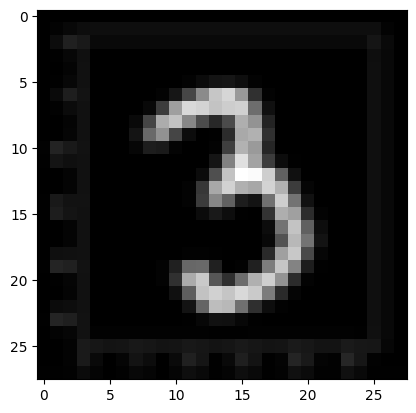

In [4]:
import cv2

img = cv2.imread('lol.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img,(28,28))
img = cv2.bitwise_not(img)
plt.imshow(img, cmap='gray')


In [5]:
img_tensor = torch.from_numpy(img)
img_tensor = img_tensor.unsqueeze(0).unsqueeze(0).float()
img_tensor = img_tensor.to(device)
output = model(img_tensor)

pred = output.argmax(dim=1,keepdim = True)
print(f"Prediction: {pred.item()}")

Prediction: 3
